In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

In [2]:
def Min(iterable):
    res = np.inf
    for x in iterable:
        res = min(x, res)
    return res

def Max(iterable):
    res = -np.inf
    for x in iterable:
        res = max(x, res)
    return res

In [3]:
from dataclasses import dataclass
from typing import Optional
from typing import Tuple
from typing import List


@dataclass
class Order:  # Our own placed order
    timestamp: float    
    order_id: int
    side: str
    size: float
    price: float


@dataclass
class AnonTrade:  # Market trade
    timestamp: float
    side: str
    size: float
    price: float


@dataclass
class OwnTrade:  # Execution of own placed order
    timestamp: float
    trade_id: int
    order_id: int
    side: str
    size: float
    price: float


@dataclass
class OrderbookSnapshotUpdate:  # Orderbook tick snapshot
    timestamp: float
    asks: List[Tuple[float, float]]  # tuple[price, size]
    bids: List[Tuple[float, float]]


@dataclass
class MdUpdate:  # Data of a tick
    orderbook: Optional[OrderbookSnapshotUpdate] = None
    trades: Optional[List[AnonTrade]] = None

In [4]:
def load_md_from_file(path: str, nrows=10000) -> List[MdUpdate]:
    lobs   = pd.read_csv(path + 'lobs.csv', nrows=nrows)
    trades = pd.read_csv(path + 'trades.csv', nrows=nrows)
    
    names = lobs.columns.values
    ln = len('btcusdt:Binance:LinearPerpetual_')
    renamer = { name:name[ln:] for name in names[2:]}
    renamer[' exchange_ts'] = 'exchange_ts'
    lobs.rename(renamer, axis=1, inplace=True)
    
    trades = trades.drop(['receive_ts'], axis=1)
    
    
    #переставляю колонки, чтобы удобнее подавать их в конструктор AnonTrade
    trades = trades[ ['exchange_ts', 'aggro_side', 'size', 'price' ] ]
    #уникальные timestamp трейдов
    ts = sorted(set(trades.exchange_ts))
    #сгруппированные по timestamp трейды
    #вначале группируем по exchange_ts, возвращается итератор пар, где первый элемент пары -- timestamp
    #а второй таблица df, соответсвующая этому timestamp
    #затем мы итерируемся по этому df и для каждого трейда создаём объект AnonTrade
    #таким образом, trades имеет тип: list[ list[AnonTrade] ]
    trades = list(  [AnonTrade(*vals) for vals in df.values] for _, df in trades.groupby('exchange_ts')  )
    
    #оставляем только ближайшие к трейдам снапшоты стакана
    ts_df = pd.DataFrame({"exchange_ts" : ts})
    lobs = pd.merge_asof(ts_df, lobs)

    #список ask_price, ask_vol для разных уровней стакана
    #размеры: len(asks) = 10, len(asks[0]) = len(lobs)
    asks = [list(zip(lobs[f"ask_price_{i}"],lobs[f"ask_vol_{i}"])) for i in range(10)]
    #транспонируем список
    asks = [ [asks[i][j] for i in range(len(asks))] for j in range(len(asks[0]))]
    #тоже самое с бидами
    bids = [list(zip(lobs[f"bid_price_{i}"],lobs[f"bid_vol_{i}"])) for i in range(10)]
    bids = [ [bids[i][j] for i in range(len(bids))] for j in range(len(bids[0]))]
    
    #список снапшотов стакана
    book = list( OrderbookSnapshotUpdate(*el) for el in zip(ts, asks, bids) )
    #возвращаем маркет дату
    return [ MdUpdate(*args) for args in zip(book, trades)]

In [5]:
class Sim:
    def __init__(self, execution_latency: float, md_latency: float, nrows : int) -> None:
        #nrows -- сколько строк маркет даты скачивать
        self.md = iter(load_md_from_file('../md/btcusdt:Binance:LinearPerpetual/', nrows))
        
        #warm-up period = 1
        self.current_md = next(self.md)
        
        self.id = 0
        self.tradeID = 0
        
        self.latency = execution_latency
        
        #словарь заявок, которые уже можно исполнять(по времени)
        self.orders = {}     #dict id->AnonOrder
        #словарь всех заявок
        self.all_orders = {} #dict id->AnonOrder
        #словарь id, которые хотим отменить
        #каждому id соотвутствует timestamp, когда уже МОЖНО удалять, т.е.
        #to_cancel[id] = latency + {время подачи заявки на отмену}
        self.to_cancel = {}#dict id->timestamp

    def tick(self) -> MdUpdate:
        
        #перебрасываем заявки из ожидающих в готовые
        #удаляем заявки, если были cancel_orders
        self.prepare_orders()
        #выполняем заявки
        trades, status = self.execute_orders()
        #make iteration
        self.current_md = next(self.md)
        return self.current_md, trades, status

    def prepare_orders(self):
        #сохраняем ключи-объекты из словаря, чтобы можно было в цикле удалять из этого словаря
        items = list(self.all_orders.items())
        #текущее время
        ts = self.current_md.orderbook.timestamp
        #итерируемся по ожидающим заявкам
        #перебрасываем заявки, которые уже можно выполнять в словарь self.order
        for _id, order in items:
            if order.timestamp <= ts:
                self.orders[_id] = order
                self.all_orders.pop(_id)
                
        #отменяем заявки, если заявка на отмену уже дошла
        items = list(self.to_cancel.items())
        for _id, _ts in items:
            if _ts <= ts:
                if _id in self.all_orders.keys():
                    self.all_orders.pop(_id)
                elif _id in self.orders.keys():
                    self.orders.pop(_id)
                self.to_cancel.pop(_id)

    def execute_orders(self):
        #текущий  ts
        ts = self.current_md.orderbook.timestamp
        
        #best_ask, best_bid
        best_ask = self.current_md.orderbook.asks[0][0]
        best_bid = self.current_md.orderbook.bids[0][0]
        
        #наименьшея цена продажи
        #если в текущей маркет дате нет таких трейдов, то цена равна +infty
        worse_ask_trade = Min(trade.price for trade in self.current_md.trades if trade.side == 'ASK')
        
        #наивысшая цена покупки
        #если таких трейдов нет, то цена равна -infty
        worse_bid_trade = Max(trade.price for trade in self.current_md.trades if trade.side == 'BID')
        
        #словарь выполненных заявок, то есть совершенных трейдов
        #так как пока что частичного исполнения нет, каждой заявке соответствует не более одного трейда
        trades = {}
        
        for ID, order in self.orders.items():
            #шаблон трейда
            
            trade = OwnTrade(ts, self.tradeID, ID, order.side, order.size, -1.0)
            if order.side == 'BID':
                if order.price >= best_ask:
                    trade.price = best_ask
                elif order.price >= worse_ask_trade:
                    trade.price = order.price
            elif order.side == 'ASK':
                if order.price <= best_bid:
                    trade.price = best_bid
                elif order.price <= worse_bid_trade:
                    trade.price = order.price
            
            #если цена трейда больше нуля, значит зашли в один из if и выполнили трейд
            #добавляем этот трейд в словарь, обновляем tradeID
            if trade.price > 0:
                self.tradeID += 1
                trades[ID] = trade
                
        #удаляем выполненные трейды из списка заявок
        for ID in trades.keys():
            self.orders.pop(ID)
        
        #статус текущих заявок
        status = {}
        
        #заявка ещё не пришла на биржу
        for ID in self.all_orders.keys():
            status[ID] = 'DELAY'
        #заявка уже поставлена, но не исполнена
        for _id in self.orders.keys():
            status[ID] = 'PLACED'
        #заявка исполнена
        for ID in trades.keys():
            status[ID] = 'EXECUTED'
        return trades, status

    def place_order(self, size, side, price):
        #добавляем заявку в список всех заявок
        #ts равен времени, когда заявка придет на биржу
        ts = self.current_md.orderbook.timestamp + self.latency
        order = Order(ts, self.id, side, size, price)
        self.all_orders[self.id] = order
        self.id += 1
        return None

    def cancel_order(self, _id):
        #добавляем заявку на удаление
        ts = self.current_md.orderbook.timestamp + self.latency
        self.to_cancel[_id] = ts
        return None

In [6]:
class BestPosStrategy:
    '''
        стратегия на каждой итерации выставляет best_bid, best_ask заявки, если не превышен лимит.
    '''
    def __init__(self, max_position: float) -> None:
        self.max_pos = max_position

    def run(self, sim: "Sim"):
        all_trades = {}
        #текущая позиция в монете и долларах
        btc_pos, usd_pos = 0.0, 0.0
        #список для маркет даты
        md = []
        #список для трейдов
        trades_list = []
        while True:
            try:
                #получаем новую маркет дату, а также список заявок, исполненных на текущей итерации
                md_update, trades, status = sim.tick()
                
                #
                best_ask = md_update.orderbook.asks[0][0]
                best_bid = md_update.orderbook.bids[0][0]
                
                #mid_price нужна для оценки текущей позиции
                mid_price = 0.5 * ( best_ask + best_bid )
                
                #current pos in btc and usd
                _btc_pos = 0.0
                _usd_pos = 0.0
                #пробегаемся по всем трейдам и считаем позицию по BTC и USD
                for ID, trade in trades.items():
                    if trade.side == 'BID':
                        _btc_pos += trade.size
                        _usd_pos -= trade.price * trade.size
                    elif trade.side == 'ASK':
                        _btc_pos -= trade.size
                        _usd_pos += trade.price * trade.size
                        
                #update positions
                btc_pos += _btc_pos
                usd_pos += _usd_pos
                
                #если не вышли за лимиты, выставляем заявки
                #лимит по долларам считаю через mid_price
                if btc_pos <= self.max_pos:
                    sim.place_order(0.001, 'BID', best_bid)
                if usd_pos <= self.max_pos * mid_price:
                    sim.place_order(0.001, 'ASK', best_ask)
                
                #добавляю выполненные трейды в словарь выполненных трейдов
                all_trades.update(trades)
                #сохраняю текущую маркет дату и трейды, выполненные на текущей итерации
                trades_list.append(trades)
                md.append(md_update)
            except StopIteration:
                break
        return all_trades, trades_list, md

In [7]:
class RandomStrategy:
    '''
        стратегия на каждой итерации случайно выставляет либо best_bid, либо best_ask
    '''
    def __init__(self, max_position: float) -> None:
        self.max_pos = max_position

    def run(self, sim: "Sim"):
        all_trades = {}
        #текущая позиция в монете и долларах
        btc_pos, usd_pos = 0.0, 0.0
        #список для маркет даты
        md = []
        #список для трейдов
        trades_list = []
        while True:
            try:
                #получаем новую маркет дату, а также список заявок, исполненных на текущей итерации
                md_update, trades, status = sim.tick()
                
                #
                best_ask = md_update.orderbook.asks[0][0]
                best_bid = md_update.orderbook.bids[0][0]
                
                #mid_price нужна для оценки текущей позиции
                mid_price = 0.5 * ( best_ask + best_bid )
                
                #current pos in btc and usd
                _btc_pos = 0.0
                _usd_pos = 0.0
                #пробегаемся по всем трейдам и считаем позицию по BTC и USD
                for ID, trade in trades.items():
                    if trade.side == 'BID':
                        _btc_pos += trade.size
                        _usd_pos -= trade.price * trade.size
                    elif trade.side == 'ASK':
                        _btc_pos -= trade.size
                        _usd_pos += trade.price * trade.size
                        
                #update positions
                btc_pos += _btc_pos
                usd_pos += _usd_pos
                
                side = np.random.choice([0, 1], 1)[0]
                if side == 0 and btc_pos <= self.max_pos:
                    sim.place_order(0.001, 'BID', best_bid)
                if side == 1 and usd_pos <= self.max_pos * mid_price:
                    sim.place_order(0.001, 'ASK', best_ask)
                
                #добавляю выполненные трейды в словарь выполненных трейдов
                all_trades.update(trades)
                #сохраняю текущую маркет дату и трейды, выполненные на текущей итерации
                trades_list.append(trades)
                md.append(md_update)
            except StopIteration:
                break
        return all_trades, trades_list, md

In [8]:
def GetPnL(trades_list, md_list):
    """
        Эта функция проходит по всем трейдам, считает позицию в usd и btc, а также суммарную позицию в долларах.
    """
    btc_pos, usd_pos = 0.0, 0.0
    
    worth = 0.0
    
    worth_list = []
    btc_pos_list = []
    usd_pos_list = []
    mid_price_list = []
    
    
    for md, trades in zip(md_list, trades_list):
        
        best_ask = md.orderbook.asks[0][0]
        best_bid = md.orderbook.bids[0][0]
        mid_price = 0.5 * ( best_ask + best_bid )
        
        _btc_pos, _usd_pos = 0.0, 0.0
        for ID, trade in trades.items():
            if trade.side == 'BID':
                _btc_pos += trade.size
                _usd_pos -= trade.price * trade.size
            elif trade.side == 'ASK':
                _btc_pos -= trade.size
                _usd_pos += trade.price * trade.size
        #update positions
        btc_pos += _btc_pos
        usd_pos += _usd_pos
        
        worth = usd_pos + mid_price * btc_pos
        worth_list.append(worth)
        btc_pos_list.append(btc_pos)
        usd_pos_list.append(usd_pos)
        mid_price_list.append(mid_price)
    ts = [md.orderbook.timestamp for md in md_list]
    df = pd.DataFrame({"ts":ts, "total":worth_list, "BTC":btc_pos_list, 
                       "USD":usd_pos_list, "mid_price":mid_price_list})
    return df


In [9]:
NROWS = 1_000_000

In [10]:
strategy = BestPosStrategy(10)

In [11]:
sim = Sim(1000, 1000, NROWS)

In [12]:
trades, trades_list, md_list = strategy.run(sim)

In [13]:
df = GetPnL(trades_list, md_list)

In [14]:
dt = pd.to_datetime(df.ts)

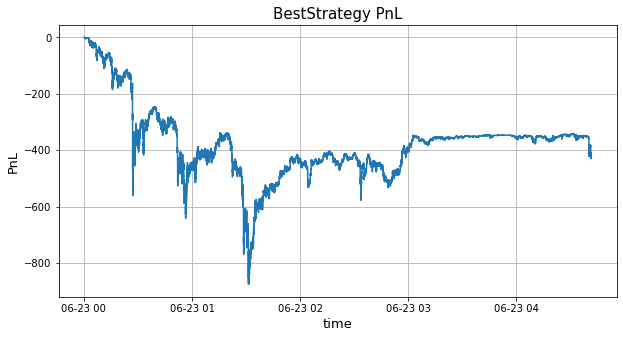

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total)
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("BestStrategy PnL", fontsize=15)
plt.grid()

In [16]:
strategy = RandomStrategy(10)
sim = Sim(1000, 1000, NROWS)

In [17]:
trades, trades_list, md_list = strategy.run(sim)

In [18]:
df = GetPnL(trades_list, md_list)

In [19]:
dt = pd.to_datetime(df.ts)

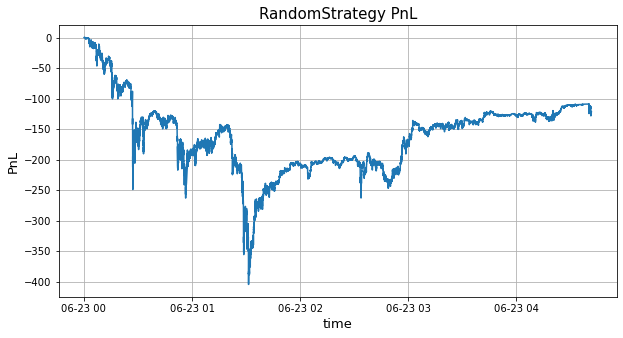

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(dt, df.total)
plt.xlabel("time", fontsize=13)
plt.ylabel("PnL", fontsize=13)
plt.title("RandomStrategy PnL", fontsize=15)
plt.grid()